In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

--2024-06-13 20:59:50--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   256MB/s    in 0.3s    

2024-06-13 20:59:50 (256 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Variables for pre-processing and training.
batch_size = 8
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
from genericpath import isdir
#! ls cats_and_dogs/test
import shutil

dest_dir: str = os.path.join(test_dir, 'test_imgs')

os.makedirs(dest_dir, exist_ok=True)

for img in os.listdir(test_dir):
  if os.path.isfile(os.path.join(test_dir, img)):
    src = os.path.join(test_dir, img)
    dst = os.path.join(dest_dir, img)
    shutil.move(src, dst)

In [ ]:
# 3
'''train_image_generator = ImageDataGenerator(
    zca_whitening=True, #ZCA (Zero-phase Component Analysis) whitening => type of data preprocessing that aims to remove redundancy in the data and ensure that the features are uncorrelated and have unit variance.
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1.0/255)

validation_image_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

test_image_generator = ImageDataGenerator(rescale=1.0/255)'''

# ffc ask to only apply reescale (╯°□°）╯︵ ┻━┻
train_image_generator = ImageDataGenerator(rescale=1.0/255)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)
test_image_generator = ImageDataGenerator(rescale=1.0/255)


train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    keep_aspect_ratio=True,
    seed=49)

val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    keep_aspect_ratio=True,
    seed=49)

test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=1,
    shuffle=False,
    keep_aspect_ratio=True,
    seed=49)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


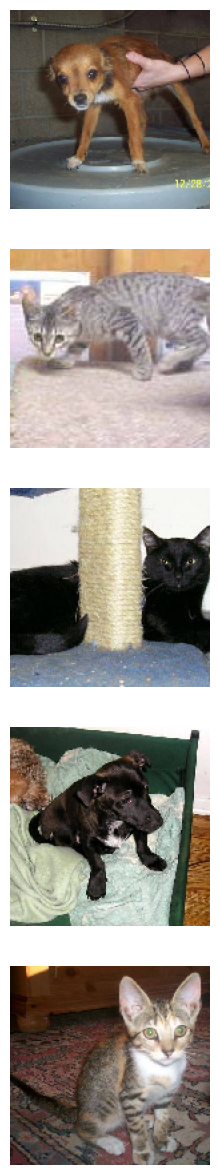

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# 5
train_image_generator = ImageDataGenerator(
    #zca_whitening=True, #ZCA (Zero-phase Component Analysis) whitening => type of data preprocessing that aims to remove redundancy in the data and ensure that the features are uncorrelated and have unit variance.
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',
    rescale=1.0/255)


Found 2000 images belonging to 2 classes.


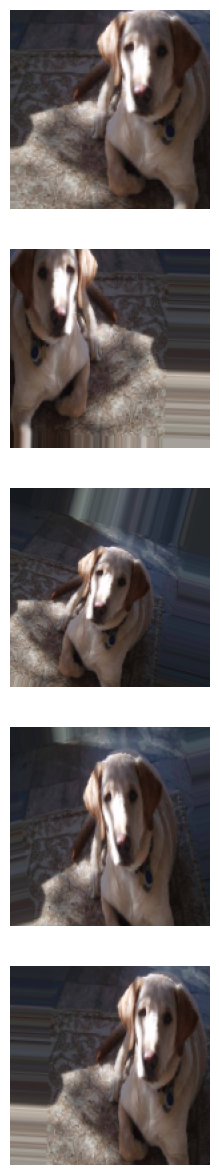

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# 7
model = Sequential()

# Replicate VGG16 model structure => VGG is made for 224x224 images, maybe not the best mode in this case
# performed horribly
'''model.add(Conv2D(64,kernel_size=(3, 3), activation='relu', padding="same",
                 input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding="same"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding="same"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding="same"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding="same"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding="same"))

model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))'''

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',
                 input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))

# it appears that more conv2d+MaxPooling layers improve acc a bit, altough the model start to heavly overfit

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.summary()

adam_optmizer = Adam(learning_rate=0.01)
SGD_optmizer = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=SGD_optmizer,
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 17, 17, 64)       

In [ ]:
# 8
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(x=train_data_gen,
                    steps_per_epoch = train_data_gen.n//train_data_gen.batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data = val_data_gen,
                    validation_steps = val_data_gen.n//val_data_gen.batch_size)

Epoch 1/15
250/250 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5195
Epoch 1: val_loss improved from inf to 0.68880, saving model to model.h5
250/250 [==============================] - 8s 29ms/step - loss: 0.6931 - accuracy: 0.5195 - val_loss: 0.6888 - val_accuracy: 0.6330


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/15
250/250 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.5450
Epoch 2: val_loss improved from 0.68880 to 0.68314, saving model to model.h5
250/250 [==============================] - 7s 27ms/step - loss: 0.6882 - accuracy: 0.5450 - val_loss: 0.6831 - val_accuracy: 0.6220
Epoch 3/15
249/250 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5597
Epoch 3: val_loss improved from 0.68314 to 0.67173, saving model to model.h5
250/250 [==============================] - 8s 32ms/step - loss: 0.6841 - accuracy: 0.5600 - val_loss: 0.6717 - val_accuracy: 0.6330
Epoch 4/15
250/250 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.5880
Epoch 4: val_loss did not improve from 0.67173
250/250 [==============================] - 7s 26ms/step - loss: 0.6740 - accuracy: 0.5880 - val_loss: 0.6837 - val_accuracy: 0.5210
Epoch 5/15
247/250 [============================>.] - ETA: 0s - loss: 0.6634 - accuracy: 0.6058
Epoch 5: val_loss i

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def loss_acc_validation_graphs(model_history):
    acc = model_history['accuracy']
    val_acc = model_history['val_accuracy']
    loss = model_history['loss']
    val_loss = model_history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

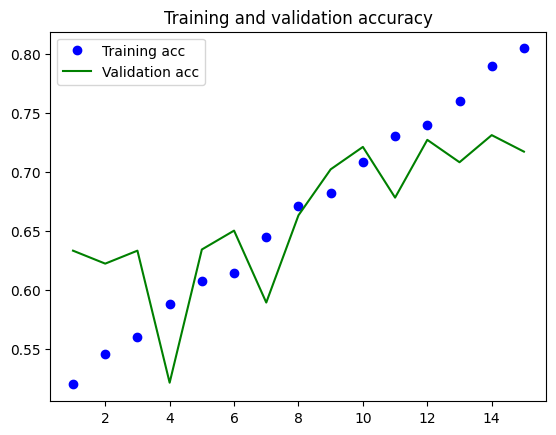

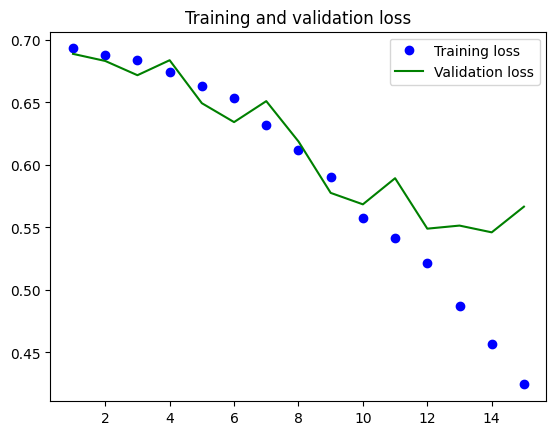

In [ ]:
loss_acc_validation_graphs(history.history)

In [ ]:
score = model.evaluate_generator(test_data_gen)
print('Test loss: {:.4}'.format(score[0])) # why is it giving me zero?
print('Test accuracy: {:.4}'.format(score[1]))

<ipython-input-99-f44e37205bdc>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_data_gen)


Test loss: 0.0
Test accuracy: 0.0


In [ ]:
# To simply get an array
predict = model.predict_generator(test_data_gen)
probabilities = predict.argmax(axis=-1)

<ipython-input-100-b0a9aef2fa74>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_data_gen)


In [ ]:
probabilities

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0])

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
